In [102]:
#####################
# Dependency import #
#####################

import seaborn as sb
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics

In [103]:
###################
# Dataset loading #
###################

dt = pd.read_csv('city_temperature.csv')
dt.head(100)

C:\Users\teodo\AppData\Local\Temp\ipykernel_3064\3705457785.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv('city_temperature.csv')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
95,Africa,Algeria,NaN,Algiers,4,6,1995,59.0
96,Africa,Algeria,NaN,Algiers,4,7,1995,54.9
97,Africa,Algeria,NaN,Algiers,4,8,1995,54.2
98,Africa,Algeria,NaN,Algiers,4,9,1995,57.8


In [104]:
#################
# Data cleaning #
#################

dt.drop(columns=["State", "Region"], axis=1, inplace=True)
dt.drop(index=dt.loc[dt["Day"] <= 0].index, inplace=True)
dt.drop(index=dt.loc[dt["AvgTemperature"] <= -20].index, inplace=True)
dt.dropna()

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...
2906322,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,US,San Juan Puerto Rico,7,30,2013,83.8


<Axes: xlabel='Year', ylabel='AvgTemperature'>

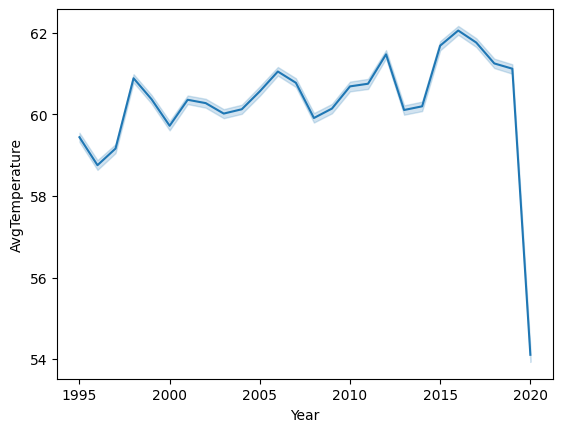

In [4]:
#######################################
# Visualisation of global temperature #
#######################################
sb.lineplot(data=dt, x="Year", y="AvgTemperature")

In [90]:
tmp = dt.groupby(by=["Day", "Month", "Year"])["AvgTemperature"].mean().reset_index()

mse = None
r2 = None

degree = 1
global_model = None

for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=tmp[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, tmp["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test) 
    
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    print("MSE:", mse)
    print("R2:", r2)
    if mse is None and r2 is None:
        mse = c_mse
        r2 = c_r2 
    else:
        if c_mse < mse:
            mse = c_mse
        elif c_r2 > r2:
            r2 = c_r2
        else:
            break
        degree = i
        global_model = _model


global_model




MSE: None
R2: None
MSE: 121.84100648275057
R2: 0.05471217224674951
MSE: 16.571536779020015
R2: 0.05471217224674951
MSE: 12.032765287500249
R2: 0.05471217224674951
MSE: 5.998707139263509
R2: 0.05471217224674951
MSE: 5.712257946658776
R2: 0.05471217224674951
MSE: 5.712257946658776
R2: 0.9533501691742647


LinearRegression()

<Axes: xlabel='Year', ylabel='AvgTemperature'>

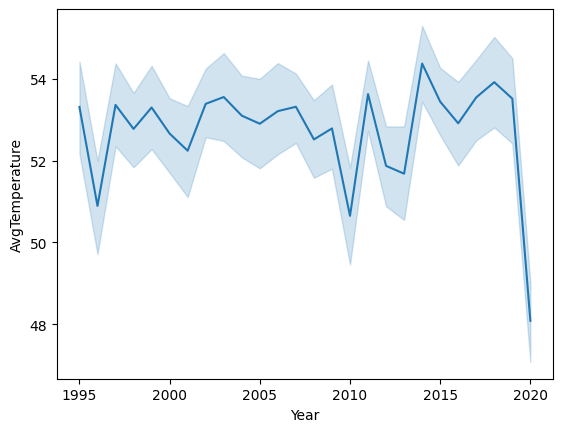

In [105]:
#########################################
# Visualisation of London's temperature #
#########################################

dtl =  dt[(dt['Country'] == 'United Kingdom') & (dt['City'] == 'London')]
sb.lineplot(data=dtl, x="Year", y="AvgTemperature")

In [ ]:
mse = None
r2 = None

mse = None
r2 = None

l_degree = 1
l_global_model = None

for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=dtl[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, dtl["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test) 
    
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    print("MSE:", mse)
    print("R2:", r2)
    if mse is None and r2 is None:
        mse = c_mse
        r2 = c_r2 
    else:
        if c_mse < mse:
            mse = c_mse
        elif c_r2 > r2:
            r2 = c_r2
        else:
            break
        l_degree = i
        l_global_model = _model



l_global_model



MSE: None
R2: None
MSE: 95.89549591123738
R2: 0.04524700222089917
MSE: 38.67269287011532
R2: 0.04524700222089917
MSE: 33.01730746581171
R2: 0.04524700222089917
MSE: 27.549940224500023
R2: 0.04524700222089917
MSE: 26.360538543037144
R2: 0.04524700222089917
MSE: 26.360538543037144
R2: 0.7325061779578956


array([[   1,    1, 1995],
       [   2,    1, 1995],
       [   3,    1, 1995],
       ...,
       [  11,    5, 2020],
       [  12,    5, 2020],
       [  13,    5, 2020]])